# MSCA 31013 BIG DATA PLATFORMS FINAL PROJECT
### GARIMA SOHI

## MODULE - 6 (TWEET UNIQUENESS ANALYSIS)

#### 6.1 Importing required packages and libraries for setting up the environment

In [1]:
import os
import shutil
import pandas as pd
from pyspark.sql.functions import *
from pyspark.sql import functions as F
from pyspark.sql.types import *

In [5]:
import pyspark 
print('Original spark.driver.maxResultSize: ' + sc._conf.get('spark.driver.maxResultSize'))
conf = pyspark.SparkConf().setAll([('spark.driver.maxResultSize', '8g')])
sc.stop()
sc = pyspark.SparkContext(conf=conf)
print('New spark.driver.maxResultSize: ' + sc._conf.get('spark.driver.maxResultSize'))


Original spark.driver.maxResultSize: 1920m


22/12/08 19:24:02 WARN org.apache.spark.SparkContext: Another SparkContext is being constructed (or threw an exception in its constructor). This may indicate an error, since only one SparkContext should be running in this JVM (see SPARK-2243). The other SparkContext was created at:
org.apache.spark.api.java.JavaSparkContext.<init>(JavaSparkContext.scala:58)
sun.reflect.NativeConstructorAccessorImpl.newInstance0(Native Method)
sun.reflect.NativeConstructorAccessorImpl.newInstance(NativeConstructorAccessorImpl.java:62)
sun.reflect.DelegatingConstructorAccessorImpl.newInstance(DelegatingConstructorAccessorImpl.java:45)
java.lang.reflect.Constructor.newInstance(Constructor.java:423)
py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:247)
py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:357)
py4j.Gateway.invoke(Gateway.java:238)
py4j.commands.ConstructorCommand.invokeConstructor(ConstructorCommand.java:80)
py4j.commands.ConstructorCommand.execute(ConstructorCommand.java:69

New spark.driver.maxResultSize: 8g


In [2]:
print('New spark.driver.maxResultSize: ' + sc._conf.get('spark.driver.maxResultSize'))

New spark.driver.maxResultSize: 1920m


In [3]:
import pandas as pd
import numpy as np
pd.set_option('display.max_colwidth', None)
pd.reset_option('display.max_rows')
from itertools import compress 
from pyspark.sql.functions import *
from pyspark.sql.types import *
from pyspark.sql import functions as F
import seaborn as sns
import matplotlib.pyplot as plt
warnings.filterwarnings(action='ignore')

In [4]:
import re
from pyspark.ml.feature import MinHashLSH
from pyspark.ml.feature import CountVectorizer,  IDF, CountVectorizerModel, Tokenizer, RegexTokenizer, StopWordsRemover
from pyspark import SparkContext
from pyspark.sql import SQLContext
from pyspark.sql import Row


In [5]:
!pip uninstall -y nltk
!pip install nltk --upgrade --no-cache-dir

Found existing installation: nltk 3.6.4
Uninstalling nltk-3.6.4:
  Successfully uninstalled nltk-3.6.4
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 28.2 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 772.3/772.3 kB 261.9 MB/s eta 0:00:00
  Attempting uninstall: regex
    Found existing installation: regex 2021.4.4
    Uninstalling regex-2021.4.4:
      Successfully uninstalled regex-2021.4.4


In [6]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [7]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.getOrCreate()
spark.conf.set("spark.sql.repl.eagerEval.enabled",True) 

#### 6.2 Reading the file

In [8]:
tweets_text = spark.read.parquet('gs://msca-bdp-students-bucket/shared_data/gsohi/bdp_final_project_2.5MM')

In [9]:
tweets_text = tweets_text.withColumn('NEWS_ORGANIZATIONS', F.when( F.col('user_description').contains('news') | \
                                              F.col('user_description').contains('wire service') | \
                                              F.col('user_description').contains('press agency') | \
                                              F.col('user_description').contains('press association') | \
                                              F.col('user_description').contains('the press') | \
                                              F.col('user_description').contains('publication') | \
                                              F.col('user_description').contains('publications'),"true")).\
withColumn('NON_PROFIT_ORGANIZATIONS', F.when( F.col('user_description').contains('nonprofit') \
                                               | F.col('user_description').contains('non-profit') \
                                               | F.col('user_description').contains('charitable') \
                                               | F.col('user_description').contains('public service') \
                                               | F.col('user_description').contains('voluntary') \
                                               | F.col('user_description').contains('cause') \
                                               | F.col('user_description').contains('public fund') \
                                               | F.col('user_description').contains('movement') \
                                               | F.col('user_description').contains('beneficiary') \
                                               | F.col('user_description').contains('philanthropic'),"true")). \
withColumn('ACADEMIC_INSTITUTIONS',
    F.when(F.col('user_name').contains('university') \
           | F.col('user_name').contains('school') \
           | F.col('user_description').contains('university') \
           | F.col('user_description').contains('school') \
           | F.col('user_description').contains('uni') \
           | F.col('user_description').contains('college') \
           | F.col('user_description').contains('research'),"true")).\
withColumn('GOVERNMENT_INSTITUTIONS',
    F.when(F.col('user_name').contains('gov') \
           | F.col('user_name').contains('govt') \
           | F.col('user_name').contains('govt.') \
           | F.col('user_name').contains('government') \
           | F.col('user_name').contains('public') \
           | F.col('user_description').contains('gov') \
           | F.col('user_description').contains('government') \
           | F.col('user_description').contains('public') \
           | F.col('user_description').contains('judiciary') \
           | F.col('user_description').contains('tutoring') \
           | F.col('user_description').contains('legislative') \
           | F.col('user_description').contains('authoritarian state') \
           | F.col('user_description').contains('civil service') \
           | F.col('user_description').contains('administrative') \
           | F.col('user_description').contains('supervisory') \
           | F.col('user_description').contains('bureaucratic'),"true")).\
withColumn('SOCIAL_MEDIA_INFLUENCERS',
    F.when( F.col('user_description').contains('influencer') \
           | F.col('user_description').contains('social media') \
           | F.col('user_description').contains('inspires') \
           | F.col('user_description').contains('motivates') \
           | F.col('user_description').contains('influences') \
           | F.col('user_description').contains('trendsetters') \
           | F.col('user_description').contains('trend') ,"true")).\
withColumn('OTHERS',
    F.when( F.col('user_description').contains('business') \
           | F.col('user_description').contains('group') \
           | F.col('user_description').contains('job portal') \
           | F.col('user_description').contains('finance') \
           | F.col('user_description').contains('banking') \
           | F.col('user_description').contains('tutoring') \
           | F.col('user_description').contains('financial') \
           | F.col('user_description').contains('social media') \
           | F.col('user_description').contains('influencer') \
           | F.col('user_description').contains('show') ,"true"))

#### 6.3 Taking 10K rows for checking the similarity of the tweet texts

In [10]:
df_text = tweets_text.limit(10000).select('text',F.substring('text',1,200), 'NEWS_ORGANIZATIONS','NON_PROFIT_ORGANIZATIONS', 'ACADEMIC_INSTITUTIONS', 'GOVERNMENT_INSTITUTIONS', 'SOCIAL_MEDIA_INFLUENCERS','OTHERS').withColumnRenamed("substring(text, 1, 50)","trimmed_text")
df_text.limit(5)  

text,"substring(text, 1, 200)",NEWS_ORGANIZATIONS,NON_PROFIT_ORGANIZATIONS,ACADEMIC_INSTITUTIONS,GOVERNMENT_INSTITUTIONS,SOCIAL_MEDIA_INFLUENCERS,OTHERS
Billlie's Schedul...,Billlie's Schedul...,null,null,null,null,null,null
220924 Yonsei Uni...,220924 Yonsei Uni...,null,null,null,null,null,null
Well look what i ...,Well look what i ...,null,null,true,null,null,null
220924 | Kyungsoo...,220924 | Kyungsoo...,null,null,true,null,null,null
@MIrfanZafar8 @Ji...,@MIrfanZafar8 @Ji...,null,null,null,null,null,null


In [11]:
df_text.count()

10000

#### 6.4 Clean the data, remove stopwords and create index

In [11]:
text = df_text.rdd.map(lambda x : x['text']).filter(lambda x: x is not None)
StopWords = stopwords.words("english")

row = Row('text')
df_text_new=text.map(row).zipWithIndex().toDF(['text','id'])
df_text_new.limit(5)

text,id
{A survivor of th...,0
{The Capital Mark...,1
{The Korea Univer...,2
{The Korea Univer...,3
{A lot of medias ...,4


In [12]:
tokens = text\
    .map( lambda document: document.strip().lower())\
    .map( lambda document: re.split(" ", document))\
    .map( lambda word: [x for x in word if len(x) > 1] )\
    .zipWithIndex()

In [13]:
df_tokens = spark.createDataFrame(tokens, ["list_of_words",'id'])

#Drop records with no tokens
df_tokens = df_tokens.where(col('list_of_words').getItem(0).isNotNull())
df_tokens.limit(5).toPandas()

,list_of_words,id
0,"[blessed, to, receive, scholarship, from, the, ohio, state, university, @ohiostatehoops, #gobucks, 🌰❤️\n\n@lindarinsights, @coachricardohil, @tuffyjunior, @jfraze, https://t.co/ntwaxuyh2x]",0
1,"[(220504), vlive, #조슈아, #joshua\n\n🦌, my, mom, also, became, korean, medicine, doctor, bit, late., it, was, when, was, still, in, 3rd, year, of, middle, school,, my, mom, was, in, her, 40s,, she, went, back, to, college,, studied, for, years, then, became, korean, medicine, doctor., age, is, just, number, https://t.co/jb0bn7gwff]",1
2,"[🧑‍🏫✏️\n\nthank, you, jami, mccallum,, kindergarten, teacher, at, goodwin, elementary, school, for, all, that, you, do, for, @d99cicero, 💙💛\n\n#wemoveforwardtogether, #ignite99, #gatorcountry🐊#teacherappreciationweek🍎, #thankateacher, \n#downloadthecicerosd99mobileapp📲]",2
3,"[tuskegee, university, launches, new, athletics, fund, campaign, to, improve, variety, of, facilities\n\n#itsthestandard\n\n🎥, https://t.co/tr2hlxqjij, https://t.co/ezg3a62yod]",3
4,"[just, in:, the, university, of, santo, tomas, (ust), suspends, classes, in, all, levels, and, office, work, on, may, and, 10,, to, encourage, students, and, employees, to, exercise, their, right, to, vote, ""for, the, sake, of, the, common, good, of, the, filipino, nation."", #walangpasok, https://t.co/8oierpzedc]",4


In [14]:
df_tokens.count()

10000

#### 6.5 Fit countvectorizer to create word features

In [15]:
# countvectorize
vectorize = CountVectorizer(inputCol="list_of_words", outputCol="features", minDF=1.0)
df_vectorize = vectorize.fit(df_tokens).transform(df_tokens) 
df_vectorize.limit(5).toPandas()

,list_of_words,id,features
0,"[survivor, of, the, texas, shooting, at, robb, elementary, school, says, gunman, remarked, to, children, ""it's, time, to, die"", before, he, killed, over, 20, people, #fox13, https://t.co/ozammv8iqv]",0,"(1.0, 2.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...)"
1,"[the, capital, market, university, challenge, is, @cmarwanda's, flagship, program, to, educate, and, instill, in, youth, the, culture, of, saving, and, investing, through, the, capital, market., \n\nabout, 1,000, students, participated, in, this, year's, #unichallengerw., https://t.co/crfd9pqcpk]",1,"(3.0, 1.0, 1.0, 2.0, 2.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...)"
2,"[the, korea, university, festival, was, added, to, red, velvet’s, lysn, schedule!, looks, like, they, will, be, attending, \n\n#irene, #아이린, #redvelvet, @rvsmtown, https://t.co/xxj61d5c42]",2,"(1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...)"
3,"[the, korea, university, festival, was, added, to, red, velvet’s, lysn, schedule!, looks, like, they, will, be, attending, \n\n#irene, #아이린, #redvelvet, @rvsmtown, https://t.co/xxj61d5c42]",3,"(1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...)"
4,"[lot, of, medias, come, to, interview, win, at, thammasart, university, \n\ncongrats, win, \n\ncr., ilyfirsty, #wingraduationday, #winmetawin, https://t.co/wdojapjlzg]",4,"(0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...)"


#### 6.6 Fit inHashLSH to create hash table

In [16]:
mh = MinHashLSH(inputCol="features", outputCol="hashes", numHashTables=5)
model = mh.fit(df_vectorize)
df_hashed = mh.fit(df_vectorize).transform(df_vectorize).cache()

In [17]:
df_hashed_text = df_text_new.join(df_hashed, "id", how = 'left')
df_hashed_text.limit(5)

id,text,list_of_words,features,hashes
0,{A survivor of th...,"[survivor, of, th...","(60610,[0,1,2,7,8...","[[4.1891233E7], [..."
1,{The Capital Mark...,"[the, capital, ma...","(60610,[0,1,2,3,4...","[[2.7257919E7], [..."
2,{The Korea Univer...,"[the, korea, univ...","(60610,[0,1,5,23,...","[[4.7945584E7], [..."
3,{The Korea Univer...,"[the, korea, univ...","(60610,[0,1,5,23,...","[[4.7945584E7], [..."
4,{A lot of medias ...,"[lot, of, medias,...","(60610,[1,2,5,8,1...","[[1.06985335E8], ..."


#### 6.7 Establish similarity threshold and return near-duplicate records

In [18]:
#Part-A: Least Jaccard Distance
jaccard_distance = 0.3

df_dups_text = model.approxSimilarityJoin(df_hashed_text, df_hashed_text, jaccard_distance).filter("datasetA.id < datasetB.id").select(
            F.col("distCol"),
            F.col("datasetA.id").alias("id_A"),
            F.col("datasetB.id").alias("id_B"),
            F.col('datasetA.text').alias('text_A'),
            F.col('datasetB.text').alias('text_B'),
#             col('datasetA.list_of_words').alias('words_A'),
#             col('datasetB.list_of_words').alias('words_B')
            )

df_dups_30 = df_dups_text

In [19]:
records = df_hashed_text.count()
dups = df_dups_text.select('id_A').distinct().count()
uniques = records - dups
dups_df = pd.DataFrame.from_dict({'duplicates': [dups], 'unique': [uniques]})

22/12/08 22:22:42 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 1019.7 KiB
22/12/08 22:22:42 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 1020.0 KiB
22/12/08 22:22:45 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 1115.5 KiB
22/12/08 22:23:55 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 1026.6 KiB
22/12/08 22:23:56 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 1009.5 KiB


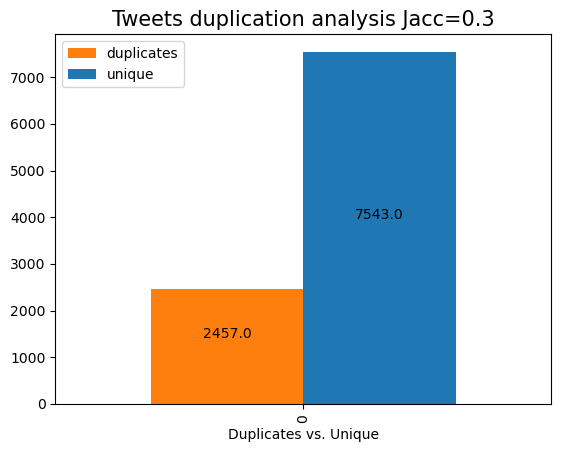

In [21]:
ax=dups_df.plot(kind = 'bar',y=['duplicates', 'unique'], fontsize=10, color=['C1', 'C0'], align='center', width=0.8, xlabel="Duplicates vs. Unique")
ax.set_title('Tweets duplication analysis Jacc=0.3', fontsize=15)
for p in ax.patches:
       ax.annotate(format(p.get_height(), '.1f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()/2), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points') 

In [20]:
#Part-B: Medium Jaccard Distance
jaccard_distance = 0.5

df_dups_text = model.approxSimilarityJoin(df_hashed_text, df_hashed_text, jaccard_distance).filter("datasetA.id < datasetB.id").select(
            F.col("distCol"),
            F.col("datasetA.id").alias("id_A"),
            F.col("datasetB.id").alias("id_B"),
            F.col('datasetA.text').alias('text_A'),
            F.col('datasetB.text').alias('text_B'),
#             col('datasetA.list_of_words').alias('words_A'),
#             col('datasetB.list_of_words').alias('words_B')
            )

df_dups_50 = df_dups_text

In [22]:
records = df_hashed_text.count()
dups = df_dups_text.select('id_A').distinct().count()
uniques = records - dups
dups_df = pd.DataFrame.from_dict({'duplicates': [dups], 'unique': [uniques]})

22/12/08 22:24:07 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 1019.7 KiB
22/12/08 22:24:07 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 1020.0 KiB
22/12/08 22:24:09 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 1115.5 KiB
22/12/08 22:25:16 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 1026.6 KiB
22/12/08 22:25:17 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 1009.5 KiB


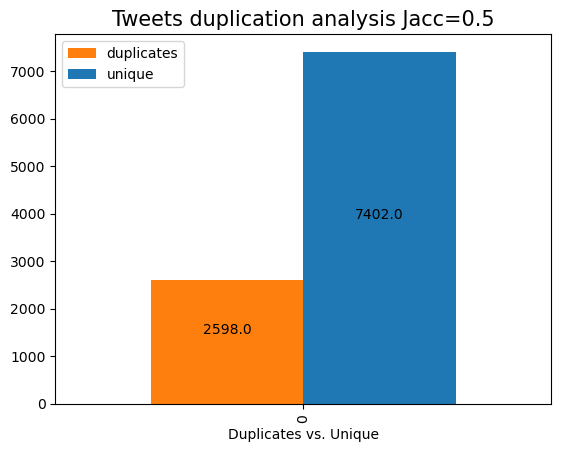

In [23]:
ax=dups_df.plot(kind = 'bar',y=['duplicates', 'unique'], fontsize=10, color=['C1', 'C0'], align='center', width=0.8, xlabel="Duplicates vs. Unique")
ax.set_title('Tweets duplication analysis Jacc=0.5', fontsize=15)
for p in ax.patches:
       ax.annotate(format(p.get_height(), '.1f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()/2), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points') 

In [24]:
#Part-C: High Jaccard Distance
jaccard_distance = 0.7

df_dups_text = model.approxSimilarityJoin(df_hashed_text, df_hashed_text, jaccard_distance).filter("datasetA.id < datasetB.id").select(
            F.col("distCol"),
            F.col("datasetA.id").alias("id_A"),
            F.col("datasetB.id").alias("id_B"),
            F.col('datasetA.text').alias('text_A'),
            F.col('datasetB.text').alias('text_B'),
#             col('datasetA.list_of_words').alias('words_A'),
#             col('datasetB.list_of_words').alias('words_B')
            )

df_dups_70 = df_dups_text

In [25]:
records = df_hashed_text.count()
dups = df_dups_text.select('id_A').distinct().count()
uniques = records - dups
dups_df = pd.DataFrame.from_dict({'duplicates': [dups], 'unique': [uniques]})

22/12/08 22:30:40 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 1019.7 KiB
22/12/08 22:30:40 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 1020.0 KiB
22/12/08 22:30:41 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 1115.3 KiB
22/12/08 22:32:34 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 1026.4 KiB
22/12/08 22:32:35 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 1009.1 KiB


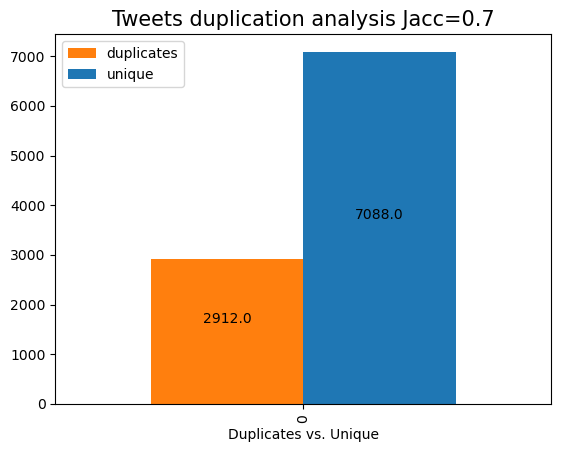

In [26]:
ax=dups_df.plot(kind = 'bar',y=['duplicates', 'unique'], fontsize=10, color=['C1', 'C0'], align='center', width=0.8, xlabel="Duplicates vs. Unique")
ax.set_title('Tweets duplication analysis Jacc=0.7', fontsize=15)
for p in ax.patches:
       ax.annotate(format(p.get_height(), '.1f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()/2), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points') 

#### 6.8 Overall comparison of the jaccard distance

In [29]:
dupDistr = pd.DataFrame(
    [(df_dups_30.select('id_A').distinct().count(),30),
     (df_dups_50.select('id_A').distinct().count(),50),
     (df_dups_70.select('id_A').distinct().count(),70)],
    index=['dups30','dups50','dups70'],
    columns=['Value','Jaccard']
)

22/12/07 20:04:34 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 1017.9 KiB
22/12/07 20:04:34 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 1018.2 KiB
22/12/07 20:04:35 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 1113.8 KiB
22/12/07 20:05:39 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 1025.0 KiB
22/12/07 20:05:43 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 1008.0 KiB
22/12/07 20:05:43 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 1017.9 KiB
22/12/07 20:05:43 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 1018.2 KiB
22/12/07 20:05:45 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 1113.9 KiB
22/12/07 20:06:35 WARN org.apache.spark.scheduler.DAGScheduler: Broadcas

Text(0.5, 1.0, 'Tweet Text Near-Duplication Distribution')

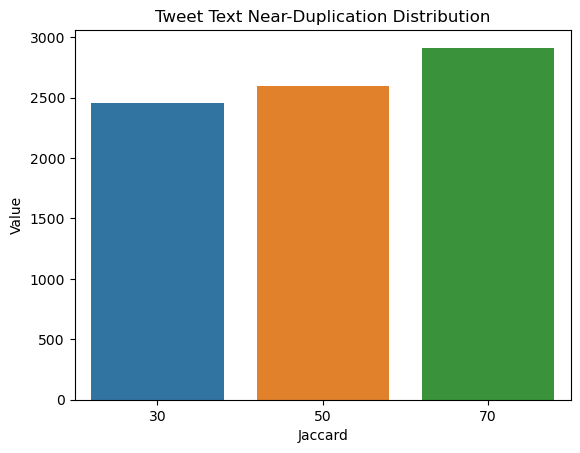

In [32]:
ax = sns.barplot(x=dupDistr.Jaccard,y=dupDistr.Value)
ax.set_title('Tweet Text Near-Duplication Distribution')

Text(0.5, 1.0, 'Tweet Text Near-Duplication Distribution')

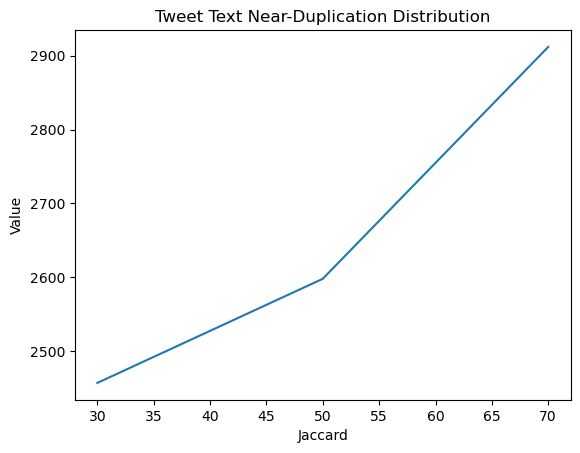

In [33]:
ax = sns.lineplot(x=dupDistr.Jaccard,y=dupDistr.Value)
ax.set_title('Tweet Text Near-Duplication Distribution')